In [324]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.layers import Input
from keras import backend as K
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import os
import time, datetime
import pickle

# pin data process
with open('pin_data_1500') as f:
    orig_pin_data = f.readlines()
    reg_pin_data = np.zeros((len(orig_pin_data),4))
    for row in range(len(orig_pin_data)):
        for col in range(4):
            reg_pin_data[row][col] = int(orig_pin_data[row][col])

with open('pin_data.pkl','wb') as f:
    pickle.dump(reg_pin_data, f)
with open('pin_data.pkl','r') as f:
    pin_data = pickle.load(f)

# motion data process
orig_motion_data = np.loadtxt('motion_data_1500')
reg_motion_data = orig_motion_data.reshape(len(orig_motion_data)/8,4,-1)
with open('motion_data.pkl','wb') as f:
    pickle.dump(reg_motion_data, f)
with open('motion_data.pkl','r') as f:
    motion_data = pickle.load(f)

In [325]:
print pin_data.shape
print motion_data.shape

(1506, 4)
(1506, 4, 24)


In [359]:
X_train, X_valid, y_train, y_valid = train_test_split(motion_data, pin_data, test_size=0.1)
# X_train = X_train.reshape((len(X_train),-1))
# X_valid = X_valid.reshape((len(X_valid),-1))
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# ss.fit(np.vstack((X_train, X_valid)))
# X_train = ss.transform(X_train)
# X_valid = ss.transform(X_valid)

# X_train = X_train.reshape((len(X_train),4,-1))
# X_valid = X_valid.reshape((len(X_valid),4,-1))

In [360]:
def convertToOneHot(vector, num_classes=10):
    vector = vector.astype(int)
    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    result = np.zeros(shape=(len(vector), 4, num_classes))
    for i in range(4):
        result[np.arange(len(vector)), i, vector[:,i]] = 1
    return result.astype(int)

def convertToNumber(array):
    result = np.zeros((len(array),4))
    for row in range(len(array)):
        for col in range(4):
            result[row][col] = np.argmax(array[row][col])
    return result.astype(int)

y_train_oh = convertToOneHot(y_train)
y_valid_oh = convertToOneHot(y_valid)
# y_train_oh = convertToOneHot(y_train).reshape((len(y_train),-1))
# y_valid_oh = convertToOneHot(y_valid).reshape((len(y_valid),-1))

In [379]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(4,24)))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(10))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc', 'categorical_accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_56 (LSTM)                   (None, 4, 50)         15000       lstm_input_37[0][0]              
____________________________________________________________________________________________________
dense_207 (Dense)                (None, 4, 1000)       51000       lstm_56[0][0]                    
____________________________________________________________________________________________________
batchnormalization_140 (BatchNor (None, 4, 1000)       4000        dense_207[0][0]                  
____________________________________________________________________________________________________
dropout_140 (Dropout)            (None, 4, 1000)       0           batchnormalization_140[0][0]     
___________________________________________________________________________________________

In [380]:
t0 = time.time()
# early_stopping =EarlyStopping(monitor='acc', patience=3)
bst_model_path = 'rnn_model.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_acc',save_best_only=True, save_weights_only=True)
# model.load_weights(bst_model_path)
history = model.fit(X_train,y_train_oh , \
        validation_data=(X_valid, y_valid_oh), \
        nb_epoch=2000, batch_size=100000, shuffle=True,verbose=0, \
        callbacks=[model_checkpoint])
t1=time.time()
print "Training ended at", datetime.datetime.now()
print "Minutes elapsed: " ,(t1 - t0) / 60.0


Training ended at 2017-06-29 13:09:40.891001
Minutes elapsed:  3.22259523074


In [381]:
import coremltools
coreml_model = coremltools.converters.keras.convert(model)
coreml_model.save('rnn_model.mlmodel')

0 : lstm_input_37, <keras.engine.topology.InputLayer object at 0x7f2c2cfa2ad0>
1 : lstm_56, <keras.layers.recurrent.LSTM object at 0x7f2c2e5a6a90>
2 : dense_207, <keras.layers.core.Dense object at 0x7f2c2cfcc950>
3 : batchnormalization_140, <keras.layers.normalization.BatchNormalization object at 0x7f2c29c6f610>
4 : dense_208, <keras.layers.core.Dense object at 0x7f2c29b05350>
5 : batchnormalization_141, <keras.layers.normalization.BatchNormalization object at 0x7f2c29ae0490>
6 : dense_209, <keras.layers.core.Dense object at 0x7f2c29a44a50>
7 : batchnormalization_142, <keras.layers.normalization.BatchNormalization object at 0x7f2c29a1cb90>
8 : dense_210, <keras.layers.core.Dense object at 0x7f2c29992790>
9 : batchnormalization_143, <keras.layers.normalization.BatchNormalization object at 0x7f2c2996a350>
10 : dense_211, <keras.layers.core.Dense object at 0x7f2c298ce910>
11 : batchnormalization_144, <keras.layers.normalization.BatchNormalization object at 0x7f2c298a8a50>
12 : dense_212, 

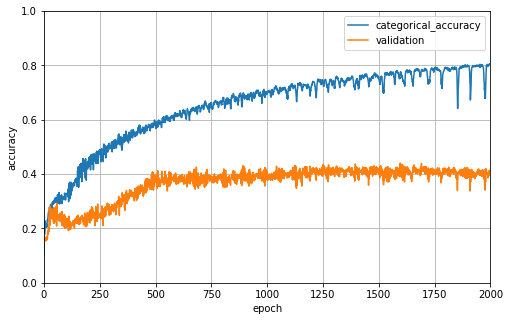

In [382]:
import pandas as pd
%matplotlib inline
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'validation': history.history['val_acc'],
                   'categorical_accuracy': history.history['categorical_accuracy']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [383]:
# results = model.predict(X_train[:10,:],batch_size=4096, verbose=1)
# print y_train[:10,:].astype(int)
# print convertToNumber(results)

results = model.predict(X_valid,batch_size=4096, verbose=1)
print 'true pin:'
print y_valid[:10,:].astype(int)
print 'predicted pin:'
print convertToNumber(results[:10,:])
print "average diff: "
print np.sum(np.abs((y_valid-convertToNumber(results))))/len(y_valid)
# print y_valid[:10,:]-convertToNumber(results)[:10,:]

151/151 [==============================] - 6s
true pin:
[[0 3 0 4]
 [8 1 8 1]
 [3 5 4 2]
 [5 1 5 1]
 [4 8 2 5]
 [4 5 7 8]
 [2 3 4 5]
 [8 5 2 3]
 [2 3 6 5]
 [5 4 7 8]]
predicted pin:
[[0 2 7 2]
 [8 1 0 4]
 [3 5 4 2]
 [2 1 9 1]
 [1 6 4 8]
 [4 5 8 0]
 [2 5 1 5]
 [0 5 4 5]
 [2 3 6 5]
 [5 4 5 5]]
average diff: 
6.75496688742
